In [1]:
include("../Inversion/Plot.jl")
include("../Inversion/KalmanInversion.jl")
include("Linear.jl")

forward_aug (generic function with 1 method)

# Two Parameter Linear Inverse Problems

Consider the 2-parameter linear inverse problem
$$y = G\theta + \eta.$$
with $\eta \sim \mathcal{N}(0, 0.1^2I)$. We explore the following three scenarios

#### non-singular (well-determined) system (NS) 
   $$
   y = \begin{bmatrix}
        3 \\
        7 
       \end{bmatrix} \quad
       G = \begin{bmatrix}
        1 & 2\\
        3 & 4
    \end{bmatrix} \quad
    \theta_{ref} = \begin{bmatrix}
        1 \\
        1 
       \end{bmatrix};
   $$ 
   
#### over-determined system (OD)
$$ y = \begin{bmatrix}
        3 \\
        7 \\
        10
       \end{bmatrix} \quad
       G = \begin{bmatrix}
        1 & 2\\
        3 & 4 \\
        5 & 6
    \end{bmatrix} \quad
    \theta_{ref} = \begin{bmatrix}
        1/3 \\
        17/12
       \end{bmatrix};
$$ 
   
#### under-determined system (UD)
$$
y = \begin{bmatrix}
        3
       \end{bmatrix} \quad
       G = \begin{bmatrix}
        1 & 2\\
    \end{bmatrix} \quad
       \theta_{ref} = \begin{bmatrix}
        1 \\
        1 
       \end{bmatrix}
       + c\begin{bmatrix}
        2 \\
        -1 
       \end{bmatrix}, \,\,c \in \mathcal{R}.
$$
   
We define $$\displaystyle \theta_{ref} = argmin_{\theta}\frac{1}{2}\lVert\Sigma_{\eta}^{-\frac{1}{2}}(y - G\theta)\rVert^2,$$ and 
note that, in the UD case, $\theta_{ref}$ comprises a one-parameter family of possible solutions. We also note that $y = G\theta_{ref}$ for NS; and 
$y = G\theta_{ref}(c^\dagger)$ for UD, with $c^{\dagger}=0$; but for OD $y \ne  G\theta_{ref}.$ 

In [2]:
function Two_Param_Linear_Test(problem_type::String, θ0_bar, θθ0_cov)
    
    N_θ = length(θ0_bar)

    
    if problem_type == "under-determined"
        # under-determined case
        θ_ref = [0.6, 1.2]
        G = [1.0 2.0;]
        
        y = [3.0;]
        Σ_η = Array(Diagonal(fill(0.1^2, size(y))))
        
        
    elseif problem_type == "well-determined"
        # over-determined case
        θ_ref = [1.0, 1.0]
        G = [1.0 2.0; 3.0 4.0]
        
        y = [3.0;7.0]
        Σ_η = Array(Diagonal(fill(0.1^2, size(y))))
        
    elseif problem_type == "over-determined"
        # over-determined case
        θ_ref = [1/3, 17/12.0]
        G = [1.0 2.0; 3.0 4.0; 5.0 6.0]
        
        y = [3.0;7.0;10.0]
        Σ_η = Array(Diagonal(fill(0.1^2, size(y))))
        
        
    else
        error("Problem type : ", problem_type, " has not implemented!")
    end
    
    Σ_post = inv(G'*(Σ_η\G) + inv(θθ0_cov))
    θ_post = θ0_bar + Σ_post*(G'*(Σ_η\(y - G*θ0_bar)))
    

    return θ_post, Σ_post, G, y, Σ_η, θ_ref
end


function construct_cov(x::Array{FT,2}) where {FT<:AbstractFloat}
    
    x_mean = dropdims(mean(x, dims=1), dims=1)
    N_ens, N_x = size(x)
    
    x_cov = zeros(FT, N_x, N_x)
    
    for i = 1: N_ens
        x_cov .+= (x[i,:] - x_mean)*(x[i,:] - x_mean)'
    end
    
    return x_cov/(N_ens - 1)
end

construct_cov (generic function with 9 methods)

## Set prior and initial conditions


In [3]:
N_θ = 2
θ0_mean = zeros(Float64, N_θ)
θθ0_cov = Array(Diagonal(fill(1.0^2, N_θ)))
θθ0_cov_sqrt = θθ0_cov

prior_mean     = θ0_mean
prior_cov      = θθ0_cov
prior_cov_sqrt = θθ0_cov_sqrt

2×2 Matrix{Float64}:
 1.0  0.0
 0.0  1.0

## Optimization approaches

In this section, different Kalman inversion algorithms (UKI, EKI, EAKI, ETKI) are applied with $\theta_0 \sim \mathcal{N}(0, I)$, on the regularized stochastic dynamical systems

$$\begin{align}
  &\textrm{evolution:}    &&\theta_{n+1} = r + \alpha (\theta_{n}  - r) +  \omega_{n+1}, &&\omega_{n+1} \sim \mathcal{N}(0,\Sigma_{\omega}),\\
  &\textrm{observation:}  &&x_{n+1} = \mathcal{F}(\theta_{n+1}) + \nu_{n+1}, &&\nu_{n+1} \sim \mathcal{N}(0,\Sigma_{\nu}).
\end{align}$$
where $\alpha = 1.0$, $\Sigma_{\nu} = 2\Sigma_{\eta}$, and $\Sigma_{\omega} = \Sigma_{0}$.


We compare them with original Kalman inversion algorithms (Orig. UKI, Orig. EKI, Orig. EAKI, Orig. ETKI), which  are applied with $\theta_0 \sim \mathcal{N}(0, I)$, on the basic stochastic dynamical systems

$$\begin{align}
  &\textrm{evolution:}    &&\theta_{n+1} = r + \alpha (\theta_{n}  - r) +  \omega_{n+1}, &&\omega_{n+1} \sim \mathcal{N}(0,\Sigma_{\omega}),\\
  &\textrm{observation:}  &&x_{n+1} = \mathcal{F}(\theta_{n+1}) + \nu_{n+1}, &&\nu_{n+1} \sim \mathcal{N}(0,\Sigma_{\nu}).
\end{align}$$
where $\alpha = 1.0$, $\Sigma_{\nu} = \Sigma_{\eta}$, and $\Sigma_{\omega} = 0$.



The convergence of the $\theta$ for all three scenarios are depicted, in terms of the $L_2$ error $\lVert m_n - \theta_{ref}\rVert_2$. Exponential convergence is achieved for UKIs on the regularized stochastic dynamical systems!

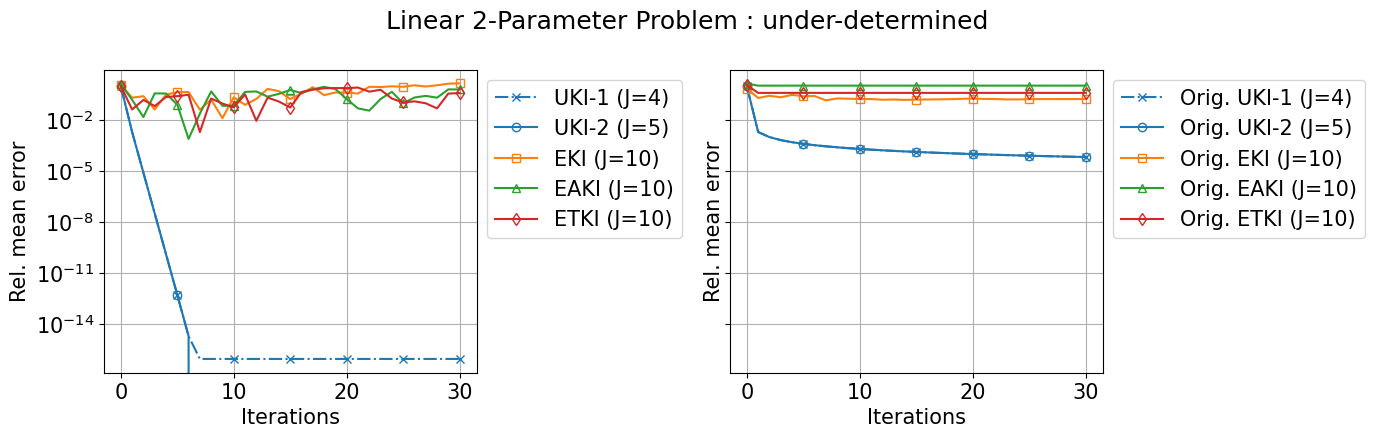

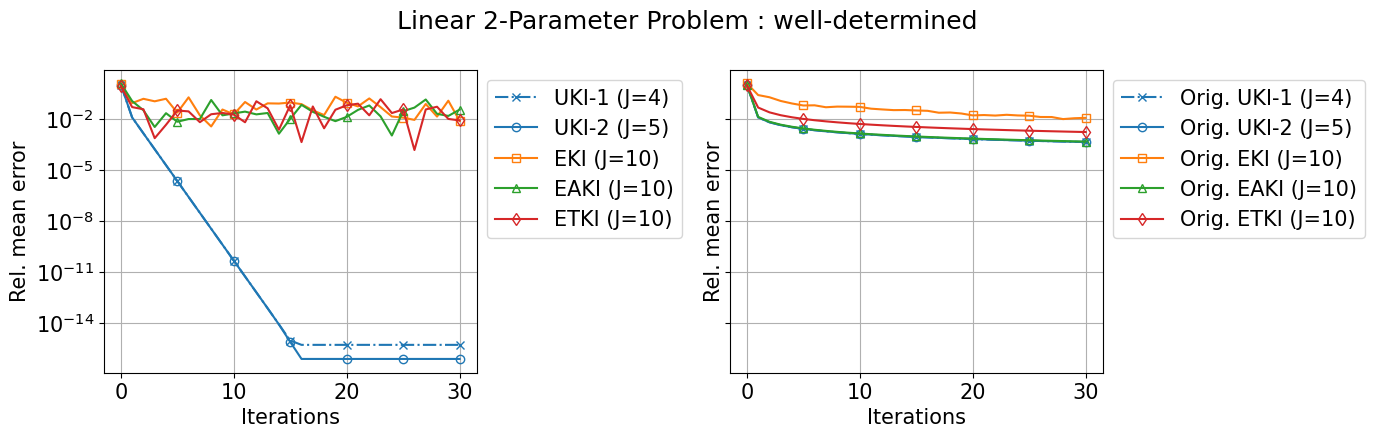

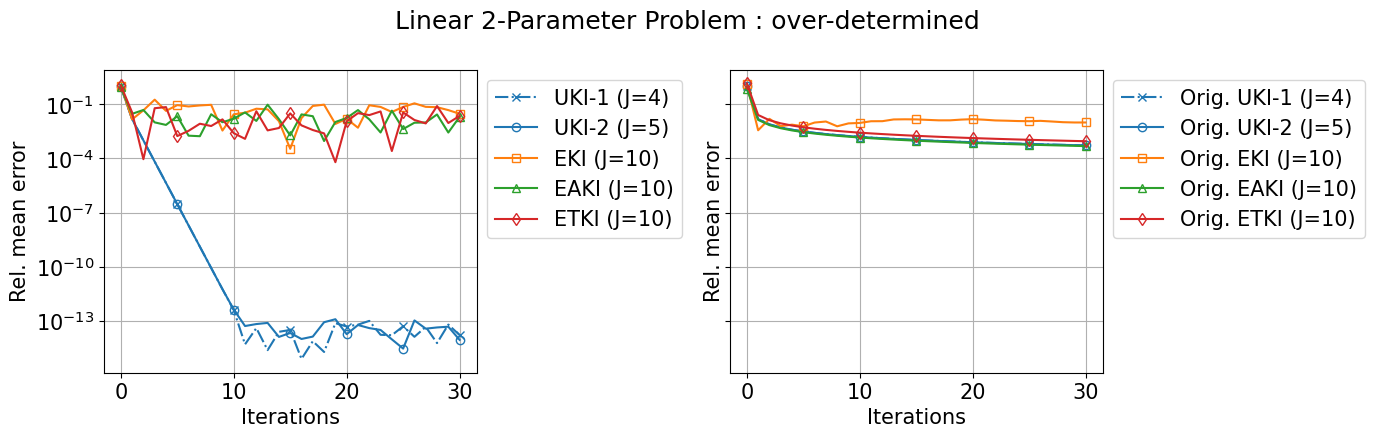

┌ Info: Start UKI on the regularized stochastic dynamical system for optimization 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/KI.jl:483
┌ Info: Start UKI on the regularized stochastic dynamical system for optimization 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/KI.jl:483
┌ Info: ("Start ", "EKI", " on the regularized stochastic dynamical system for optimization ")
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/KI.jl:95
┌ Info: ("Start ", "ETKI", " on the regularized stochastic dynamical system for optimization ")
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/KI.jl:95
┌ Info: ("Start ", "EAKI", " on the regularized stochastic dynamical system for optimization ")
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/KI.jl:95
┌ Info: Start original UKI for optimization 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/KI.jl:477
┌ Info: Start origi

In [4]:
FT = Float64
uki_objs = Dict()
mean_errors = Dict()

Random.seed!(123)
α_reg = 1.0
update_freq = 0
N_iter = 30




for problem_type in ("under-determined", "well-determined", "over-determined")
    
    θ_post, Σ_post, G, y, Σ_η, θ_ref = Two_Param_Linear_Test(problem_type, θ0_mean, θθ0_cov)
    
    N_y = length(y)
    
    s_param = Setup_Param(G, N_θ, N_y)
    N_ens = 10
    
    γ = 2.0
    uki_obj      = UKI_Run(s_param, forward, θ0_mean, θθ0_cov, prior_mean, prior_cov, y, Σ_η, γ, α_reg, update_freq, N_iter; unscented_transform="modified-n+2")
    # UKI
    uki_2np1_obj = UKI_Run(s_param, forward, θ0_mean, θθ0_cov, prior_mean, prior_cov, y, Σ_η, γ, α_reg, update_freq, N_iter; unscented_transform="modified-2n+1")
    # EKI
    eki_obj = EKI_Run(s_param, forward, "EKI", θ0_mean, θθ0_cov_sqrt, prior_mean, prior_cov_sqrt, N_ens, y, Σ_η, γ, α_reg, update_freq, N_iter)
    # ETKI
    etki_obj = EKI_Run(s_param, forward, "ETKI", θ0_mean, θθ0_cov_sqrt, prior_mean, prior_cov_sqrt, N_ens, y, Σ_η, γ, α_reg, update_freq, N_iter)
    # EAKI
    eaki_obj = EKI_Run(s_param, forward, "EAKI", θ0_mean, θθ0_cov_sqrt, prior_mean, prior_cov_sqrt, N_ens, y, Σ_η, γ, α_reg, update_freq, N_iter)
    
    
    
    γ = 1.0
    uki_orig_obj      = UKI_Run(s_param, forward, θ0_mean, θθ0_cov, prior_mean, prior_cov, y, Σ_η, γ, α_reg, update_freq, N_iter; unscented_transform="modified-n+2")
    # UKI
    uki_orig_2np1_obj = UKI_Run(s_param, forward, θ0_mean, θθ0_cov, prior_mean, prior_cov, y, Σ_η, γ, α_reg, update_freq, N_iter; unscented_transform="modified-2n+1")
    # EKI
    eki_orig_obj = EKI_Run(s_param, forward, "EKI", θ0_mean, θθ0_cov_sqrt, prior_mean, prior_cov_sqrt, N_ens, y, Σ_η, γ, α_reg, update_freq, N_iter)
    # ETKI
    etki_orig_obj = EKI_Run(s_param, forward, "ETKI", θ0_mean, θθ0_cov_sqrt, prior_mean, prior_cov_sqrt, N_ens, y, Σ_η, γ, α_reg, update_freq, N_iter)
    # EAKI
    eaki_orig_obj = EKI_Run(s_param, forward, "EAKI", θ0_mean, θθ0_cov_sqrt, prior_mean, prior_cov_sqrt, N_ens, y, Σ_η, γ, α_reg, update_freq, N_iter)
    


    
    uki_errors = zeros(FT, N_iter+1, 1)
    uki_2np1_errors = zeros(FT, N_iter+1, 1)
    eki_errors = zeros(FT, N_iter+1, 1)
    eaki_errors = zeros(FT, N_iter+1, 1)
    etki_errors = zeros(FT, N_iter+1, 1)
    
    uki_orig_errors = zeros(FT, N_iter+1, 1)
    uki_orig_2np1_errors = zeros(FT, N_iter+1, 1)
    eki_orig_errors = zeros(FT, N_iter+1, 1)
    eaki_orig_errors = zeros(FT, N_iter+1, 1)
    etki_orig_errors = zeros(FT, N_iter+1, 1)
    
    
    for i = 1:N_iter+1
        uki_errors[i] = norm(uki_obj.θ_mean[i] .- θ_ref)/norm(θ_ref)
        uki_2np1_errors[i] = norm(uki_2np1_obj.θ_mean[i] .- θ_ref)/norm(θ_ref)
        eki_errors[i, 1] = norm(dropdims(mean(eki_obj.θ[i], dims=1), dims=1) .- θ_ref)/norm(θ_ref)
        eaki_errors[i, 1] = norm(dropdims(mean(eaki_obj.θ[i], dims=1), dims=1) .- θ_ref)/norm(θ_ref)
        etki_errors[i, 1] = norm(dropdims(mean(etki_obj.θ[i], dims=1), dims=1) .- θ_ref)/norm(θ_ref)
        
        uki_orig_errors[i] = norm(uki_orig_obj.θ_mean[i] .- θ_ref)/norm(θ_ref)
        uki_orig_2np1_errors[i] = norm(uki_orig_2np1_obj.θ_mean[i] .- θ_ref)/norm(θ_ref)
        eki_orig_errors[i, 1] = norm(dropdims(mean(eki_orig_obj.θ[i], dims=1), dims=1) .- θ_ref)/norm(θ_ref)
        eaki_orig_errors[i, 1] = norm(dropdims(mean(eaki_orig_obj.θ[i], dims=1), dims=1) .- θ_ref)/norm(θ_ref)
        etki_orig_errors[i, 1] = norm(dropdims(mean(etki_orig_obj.θ[i], dims=1), dims=1) .- θ_ref)/norm(θ_ref)
        
    end
    
    ites = Array(0:N_iter)
    
    markevery = 5
    
    fig, ax = PyPlot.subplots(nrows = 1, ncols=2, sharex=false, sharey="row", figsize=(14,4.5))
    ax[1].semilogy(ites, uki_errors,   "-.x", color = "C0", fillstyle="none", label="UKI-1 (J=$(N_θ+2))", markevery = markevery)
    ax[1].semilogy(ites, uki_2np1_errors,   "-o", color = "C0", fillstyle="none", label="UKI-2 (J=$(2*N_θ+1))", markevery = markevery)
    ax[1].semilogy(ites, eki_errors, "-s", color = "C1", fillstyle="none", label="EKI (J=$N_ens)", markevery = markevery)
    ax[1].semilogy(ites, eaki_errors, "-^", color = "C2", fillstyle="none", label="EAKI (J=$N_ens)", markevery = markevery)
    ax[1].semilogy(ites, etki_errors, "-d", color = "C3", fillstyle="none", label="ETKI (J=$N_ens)", markevery = markevery)
    ax[1].set_xlabel("Iterations")
    ax[1].set_ylabel("Rel. mean error")
    ax[1].grid("on")
    ax[1].legend(bbox_to_anchor=(1.0, 1.0))
    
    ax[2].semilogy(ites, uki_orig_errors,   "-.x", color = "C0", fillstyle="none", label="Orig. UKI-1 (J=$(N_θ+2))", markevery = markevery)
    ax[2].semilogy(ites, uki_orig_2np1_errors,   "-o", color = "C0", fillstyle="none", label="Orig. UKI-2 (J=$(2*N_θ+1))", markevery = markevery)
    ax[2].semilogy(ites, eki_orig_errors, "-s", color = "C1", fillstyle="none", label="Orig. EKI (J=$N_ens)", markevery = markevery)
    ax[2].semilogy(ites, eaki_orig_errors, "-^", color = "C2", fillstyle="none", label="Orig. EAKI (J=$N_ens)", markevery = markevery)
    ax[2].semilogy(ites, etki_orig_errors, "-d", color = "C3", fillstyle="none", label="Orig. ETKI (J=$N_ens)", markevery = markevery)
    ax[2].set_xlabel("Iterations")
    ax[2].set_ylabel("Rel. mean error")
    ax[2].grid("on")
    ax[2].legend(bbox_to_anchor=(1.0, 1.0))

     
    
    fig.suptitle("Linear 2-Parameter Problem : " * problem_type)
    fig.tight_layout()
    
end







## Probabilistic approaches

In this section, different Kalman inversion algorithms (UKI, EKI, EAKI, ETKI) are applied with $\theta_0 \sim \mathcal{N}(0, I)$, on the mean-field stochastic dynamical systems

$$\begin{align}
  &\textrm{evolution:}    &&\theta_{n+1} = r + \alpha (\theta_{n}  - r) +  \omega_{n+1}, &&\omega_{n+1} \sim \mathcal{N}(0,\Sigma_{\omega}),\\
  &\textrm{observation:}  &&x_{n+1} = \mathcal{F}(\theta_{n+1}) + \nu_{n+1}, &&\nu_{n+1} \sim \mathcal{N}(0,\Sigma_{\nu}).
\end{align}$$
where $\alpha = 1.0$, $\Sigma_{\omega} = \gamma C_n$, $\Sigma_{\nu} = \frac{\gamma+1}{\gamma}\Sigma_{\eta}$, and $\gamma = 1.0$.


We compare them with iterative Kalman inversion algorithms (IUKF, IEKF, IEAKF, IETKF), which  transport the prior to the 
posterior in one time unit. We also compare them with recently proposed Gaussian approximation algorithms, ensemble Kalman sampler (EKS), 
and censensus-based sampler (CBS).

The convergence of the posterior mean and covariance are depicted.
Exponential convergence is achieved for UKIs, EAKI and ETKI on the mean-field stochastic dynamical systems!

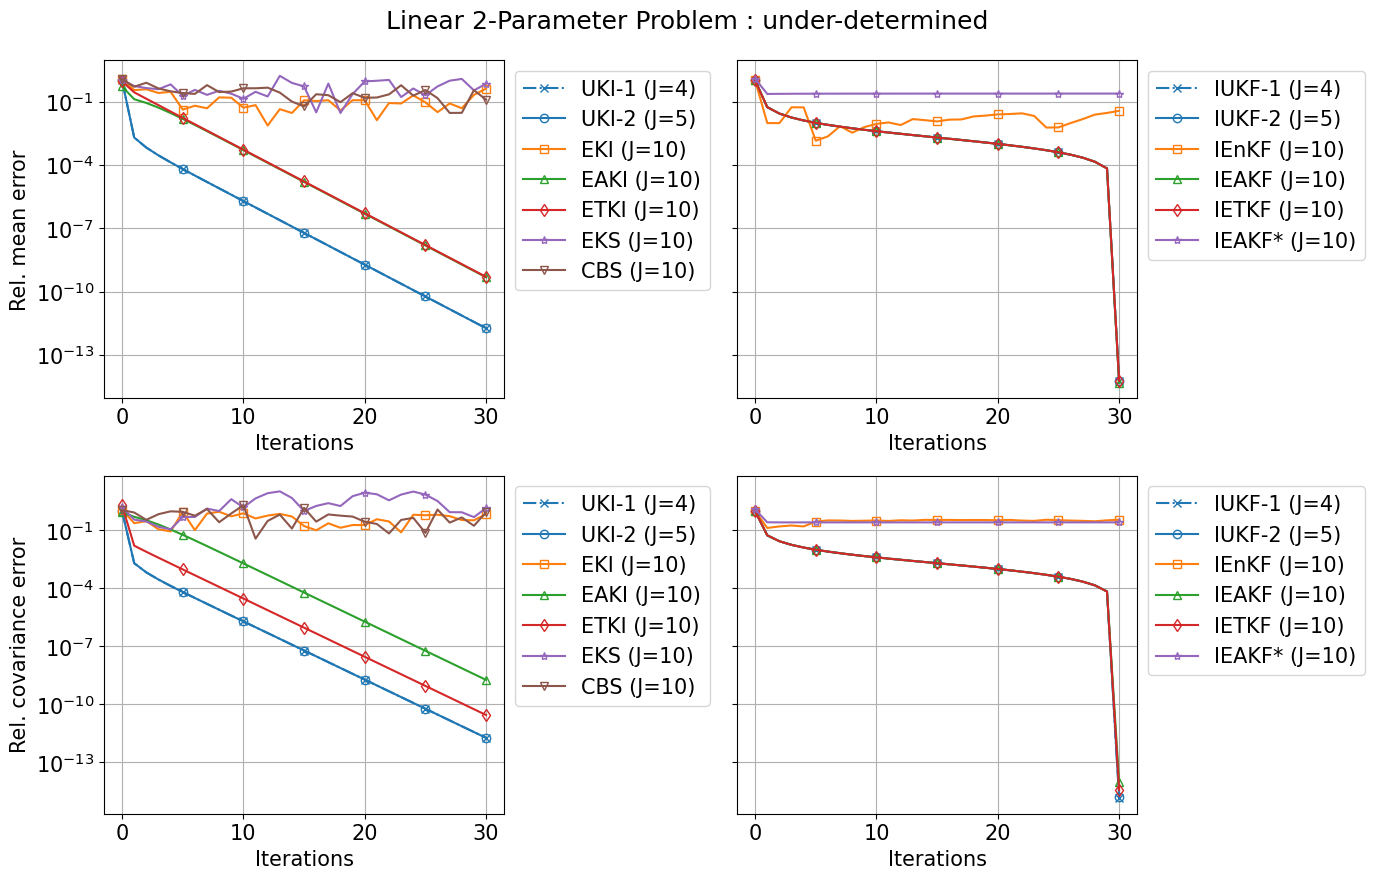

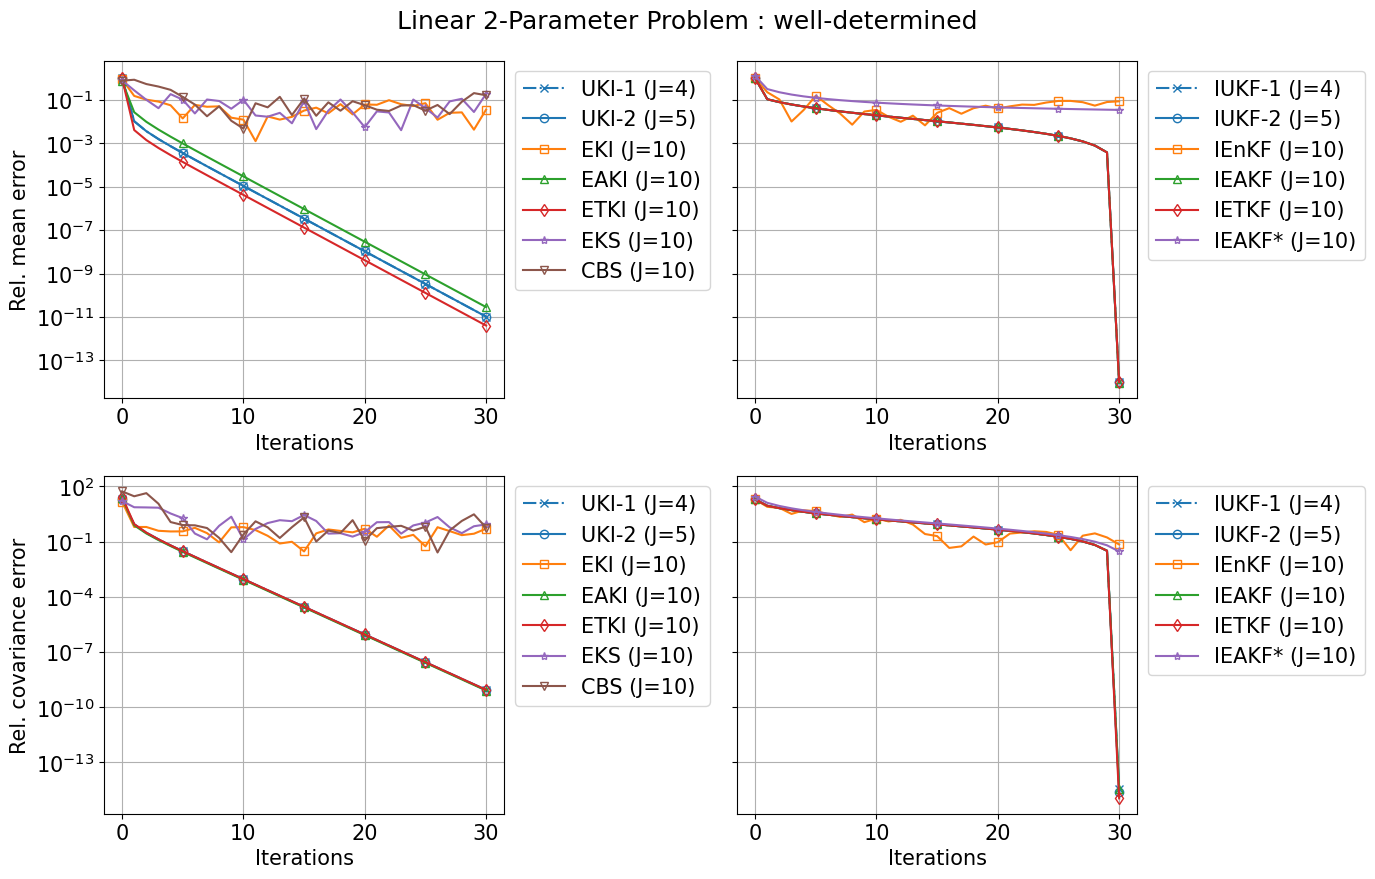

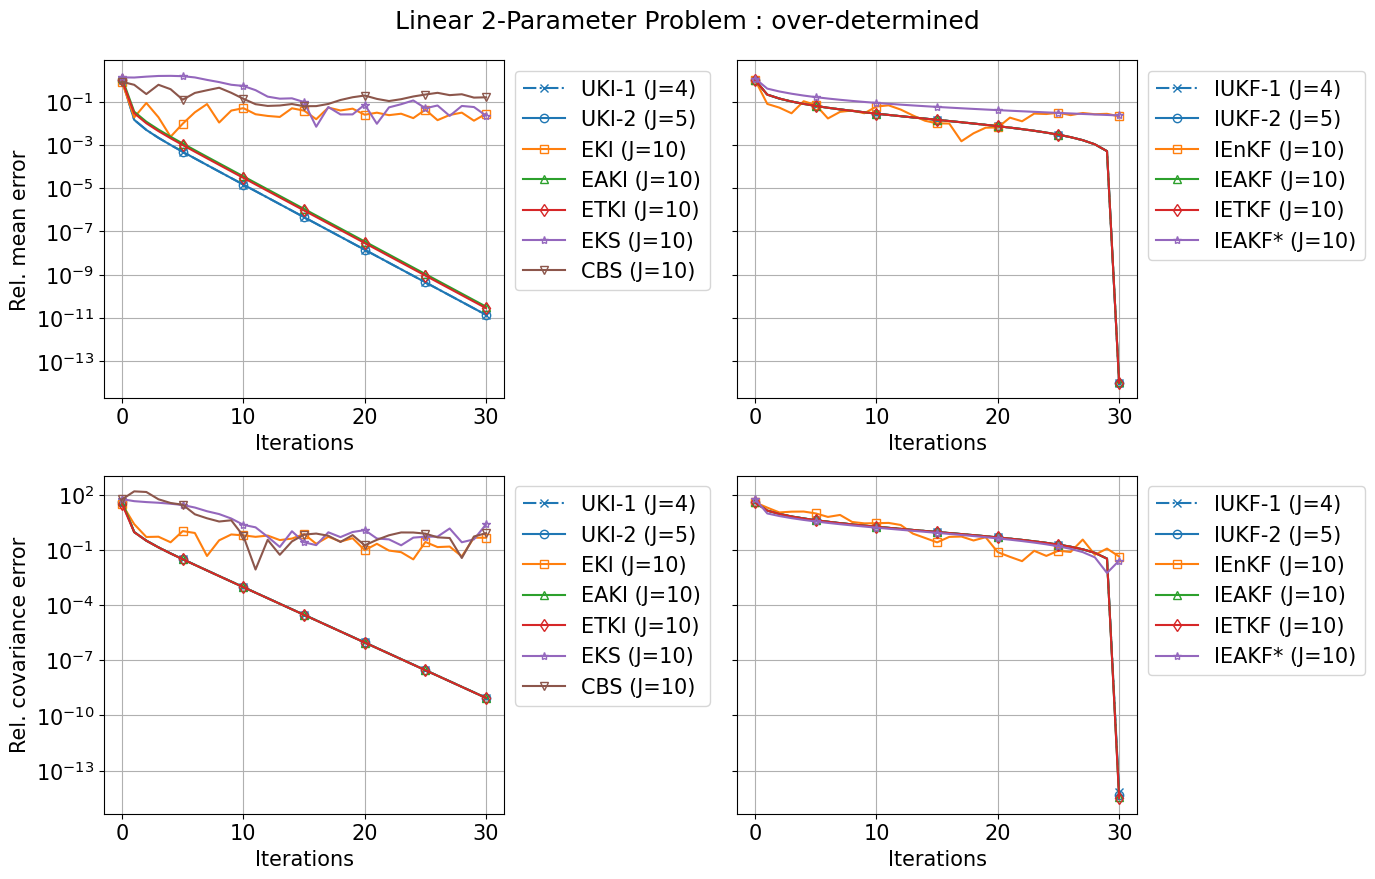

┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/KI.jl:469
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/KI.jl:469
┌ Info: ("Start ", "EKI", " on the mean-field stochastic dynamical system for Bayesian inference ")
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/KI.jl:82
┌ Info: ("Start ", "ETKI", " on the mean-field stochastic dynamical system for Bayesian inference ")
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/KI.jl:82
┌ Info: ("Start ", "EAKI", " on the mean-field stochastic dynamical system for Bayesian inference ")
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/KI.jl:82
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /Users/huang/Desktop/Co

In [6]:
FT = Float64
uki_objs = Dict()
mean_errors = Dict()

Random.seed!(123)
α_reg = 1.0
update_freq = 1
γ = 1.0
N_iter = 30
for problem_type in ("under-determined", "well-determined", "over-determined")
    
    θ_post, Σ_post, G, y, Σ_η, θ_ref = Two_Param_Linear_Test(problem_type, θ0_mean, θθ0_cov)
    
    N_y = length(y)
    
    s_param = Setup_Param(G, N_θ, N_y)
    s_param_aug = Setup_Param(G, N_θ, N_y+N_θ)
    
        
    y_aug = [y ;θ0_mean]
    Σ_η_aug = [Σ_η zeros(Float64, N_y, N_θ); zeros(Float64, N_θ, N_y)  θθ0_cov]
    N_ens = 10
    
    
    # UKI
    uki_obj      = UKI_Run(s_param_aug, forward_aug, θ0_mean, θθ0_cov, prior_mean, prior_cov, y_aug, Σ_η_aug, γ, α_reg, update_freq, N_iter; unscented_transform="modified-n+2")
    # UKI
    uki_2np1_obj = UKI_Run(s_param_aug, forward_aug, θ0_mean, θθ0_cov, prior_mean, prior_cov, y_aug, Σ_η_aug, γ, α_reg, update_freq, N_iter; unscented_transform="modified-2n+1")
    # EKI
    eki_obj = EKI_Run(s_param_aug, forward_aug, "EKI", θ0_mean, θθ0_cov_sqrt, prior_mean, prior_cov_sqrt, N_ens,
    y_aug, Σ_η_aug, γ, α_reg, update_freq, N_iter)
    # ETKI
    etki_obj = EKI_Run(s_param_aug, forward_aug, "ETKI", θ0_mean, θθ0_cov_sqrt, prior_mean, prior_cov_sqrt, N_ens,
    y_aug, Σ_η_aug, γ, α_reg, update_freq, N_iter)
    # EAKI
    eaki_obj = EKI_Run(s_param_aug, forward_aug, "EAKI", θ0_mean, θθ0_cov_sqrt, prior_mean, prior_cov_sqrt, N_ens,
    y_aug, Σ_η_aug, γ, α_reg, update_freq, N_iter)
    # EKS
    eks_obj = EKS_Run(s_param, forward, θ0_mean, θθ0_cov, N_ens, y, Σ_η, N_iter)
    # CBS
    cbs_obj = CBS_Run(s_param, forward, θ0_mean, θθ0_cov, N_ens, y, Σ_η, N_iter, 0.0)

    # IUKF
    iukf_obj = IUKF_Run(s_param, forward, θ0_mean, θθ0_cov, y, Σ_η, N_iter; unscented_transform="modified-n+2")
    iukf_2np1_obj =  IUKF_Run(s_param, forward, θ0_mean, θθ0_cov, y, Σ_η, N_iter; unscented_transform="modified-2n+1")
    # IEKF
    iekf_obj  = IEKF_Run("EKI",  s_param, forward, θ0_mean, θθ0_cov, N_ens, y, Σ_η, N_iter; exact_init=true)
    # IETKF
    ietkf_obj = IEKF_Run("ETKI", s_param, forward, θ0_mean, θθ0_cov, N_ens, y, Σ_η, N_iter; exact_init=true)
    # IEAKF
    ieakf_obj = IEKF_Run("EAKI", s_param, forward, θ0_mean, θθ0_cov, N_ens, y, Σ_η, N_iter; exact_init=true)
    ieakf_false_obj = IEKF_Run("EAKI", s_param, forward, θ0_mean, θθ0_cov, N_ens, y, Σ_η, N_iter; exact_init=false)
    
    

    
    
    
    uki_errors    = zeros(FT, N_iter+1, 2)
    uki_2np1_errors = zeros(FT, N_iter+1, 2)
    eki_errors  = zeros(FT, N_iter+1, 2)
    eaki_errors = zeros(FT, N_iter+1, 2)
    etki_errors = zeros(FT, N_iter+1, 2)
    eks_errors  = zeros(FT, N_iter+1, 2)
    cbs_errors  = zeros(FT, N_iter+1, 2)
    iukf_errors  = zeros(FT, N_iter+1, 2)
    iukf_2np1_errors = zeros(FT, N_iter+1, 2)
    iekf_errors  = zeros(FT, N_iter+1, 2)
    ietkf_errors = zeros(FT, N_iter+1, 2)
    ieakf_errors = zeros(FT, N_iter+1, 2)
    ieakf_false_errors = zeros(FT, N_iter+1, 2)
    
    
    for i = 1:N_iter+1
        uki_errors[i, 1] = norm(uki_obj.θ_mean[i] .- θ_post)/norm(θ_post)
        uki_errors[i, 2] = norm(uki_obj.θθ_cov[i] .- Σ_post)/norm(Σ_post)
        
        uki_2np1_errors[i, 1] = norm(uki_2np1_obj.θ_mean[i] .- θ_post)/norm(θ_post)
        uki_2np1_errors[i, 2] = norm(uki_2np1_obj.θθ_cov[i] .- Σ_post)/norm(Σ_post)
         
        eki_errors[i, 1] = norm(dropdims(mean(eki_obj.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        eki_errors[i, 2] = norm(construct_cov(eki_obj.θ[i]) .- Σ_post)/norm(Σ_post)
        
        eaki_errors[i, 1] = norm(dropdims(mean(eaki_obj.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        eaki_errors[i, 2] = norm(construct_cov(eaki_obj.θ[i]) .- Σ_post)/norm(Σ_post)
        
        etki_errors[i, 1] = norm(dropdims(mean(etki_obj.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        etki_errors[i, 2] = norm(construct_cov(etki_obj.θ[i]) .- Σ_post)/norm(Σ_post)
        
        eks_errors[i, 1] = norm(dropdims(mean(eks_obj.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        eks_errors[i, 2] = norm(construct_cov(eks_obj.θ[i]) .- Σ_post)/norm(Σ_post)
        
        cbs_errors[i, 1] = norm(dropdims(mean(cbs_obj.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        cbs_errors[i, 2] = norm(construct_cov(cbs_obj.θ[i]) .- Σ_post)/norm(Σ_post)
        
        ###################
        iukf_errors[i, 1] = norm(iukf_obj.θ_mean[i] .- θ_post)/norm(θ_post)
        iukf_errors[i, 2] = norm(iukf_obj.θθ_cov[i] .- Σ_post)/norm(Σ_post)
        
        iukf_2np1_errors[i, 1] = norm(iukf_2np1_obj.θ_mean[i] .- θ_post)/norm(θ_post)
        iukf_2np1_errors[i, 2] = norm(iukf_2np1_obj.θθ_cov[i] .- Σ_post)/norm(Σ_post)
        
        iekf_errors[i, 1] = norm(dropdims(mean(iekf_obj.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        iekf_errors[i, 2] = norm(construct_cov(iekf_obj.θ[i]) .- Σ_post)/norm(Σ_post)
        
        ietkf_errors[i, 1] = norm(dropdims(mean(ietkf_obj.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        ietkf_errors[i, 2] = norm(construct_cov(ietkf_obj.θ[i]) .- Σ_post)/norm(Σ_post)
        
        ieakf_errors[i, 1] = norm(dropdims(mean(ieakf_obj.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        ieakf_errors[i, 2] = norm(construct_cov(ieakf_obj.θ[i]) .- Σ_post)/norm(Σ_post)
        
        ieakf_false_errors[i, 1] = norm(dropdims(mean(ieakf_false_obj.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        ieakf_false_errors[i, 2] = norm(construct_cov(ieakf_false_obj.θ[i]) .- Σ_post)/norm(Σ_post)
        
    end
    
    ites = Array(0:N_iter)
    

    markevery = 5
    
    fig, ax = PyPlot.subplots(nrows = 2, ncols=2, sharex=false, sharey="row", figsize=(14,9))
    ax[1,1].semilogy(ites, uki_errors[:, 1],   "-.x", color = "C0", fillstyle="none", label="UKI-1 (J=$(N_θ+2))", markevery = markevery)
    ax[1,1].semilogy(ites, uki_2np1_errors[:, 1],   "-o", color = "C0", fillstyle="none", label="UKI-2 (J=$(2*N_θ+1))", markevery = markevery)
    ax[1,1].semilogy(ites, eki_errors[:, 1], "-s", color = "C1", fillstyle="none", label="EKI (J=$N_ens)", markevery = markevery)
    ax[1,1].semilogy(ites, eaki_errors[:, 1], "-^", color = "C2", fillstyle="none", label="EAKI (J=$N_ens)", markevery = markevery)
    ax[1,1].semilogy(ites, etki_errors[:, 1], "-d", color = "C3", fillstyle="none", label="ETKI (J=$N_ens)", markevery = markevery)
    ax[1,1].semilogy(ites, eks_errors[:, 1], "-*", color = "C4", fillstyle="none", label="EKS (J=$N_ens)", markevery = markevery)
    ax[1,1].semilogy(ites, cbs_errors[:, 1], "-v", color = "C5", fillstyle="none", label="CBS (J=$N_ens)", markevery = markevery)
    ax[1,1].set_xlabel("Iterations")
    ax[1,1].set_ylabel("Rel. mean error")
    ax[1,1].grid("on")
    ax[1,1].legend(bbox_to_anchor=(1.0, 1.0))
    
    ax[1,2].semilogy(ites, iukf_errors[:, 1],   "-.x", color = "C0", fillstyle="none", label="IUKF-1 (J=$(N_θ+2))", markevery = markevery)
    ax[1,2].semilogy(ites, iukf_2np1_errors[:, 1],   "-o", color = "C0", fillstyle="none", label="IUKF-2 (J=$(2*N_θ+1))", markevery = markevery)
    ax[1,2].semilogy(ites, iekf_errors[:, 1], "-s", color = "C1", fillstyle="none", label="IEnKF (J=$N_ens)", markevery = markevery)
    ax[1,2].semilogy(ites, ieakf_errors[:, 1], "-^", color = "C2", fillstyle="none", label="IEAKF (J=$N_ens)", markevery = markevery)
    ax[1,2].semilogy(ites, ietkf_errors[:, 1], "-d", color = "C3", fillstyle="none", label="IETKF (J=$N_ens)", markevery = markevery)
    # Initialization
    ax[1,2].semilogy(ites, ieakf_false_errors[:, 1], "-*", color = "C4", fillstyle="none", label="IEAKF* (J=$N_ens)", markevery = markevery)
    
    ax[1,2].set_xlabel("Iterations")
    #ax[1,2].set_ylabel("Rel. mean error")
    ax[1,2].grid("on")
    ax[1,2].legend(bbox_to_anchor=(1.0, 1.0))

    ax[2,1].semilogy(ites, uki_errors[:, 2],   "-.x", color = "C0", fillstyle="none", label="UKI-1 (J=$(N_θ+2))", markevery = markevery)
    ax[2,1].semilogy(ites, uki_2np1_errors[:, 2],   "-o", color = "C0", fillstyle="none", label="UKI-2 (J=$(2*N_θ+1))", markevery = markevery)
    ax[2,1].semilogy(ites, eki_errors[:, 2], "-s", color = "C1", fillstyle="none", label="EKI (J=$N_ens)", markevery = markevery)
    ax[2,1].semilogy(ites, eaki_errors[:, 2], "-^", color = "C2", fillstyle="none", label="EAKI (J=$N_ens)", markevery = markevery)
    ax[2,1].semilogy(ites, etki_errors[:, 2], "-d", color = "C3", fillstyle="none", label="ETKI (J=$N_ens)", markevery = markevery)
    ax[2,1].semilogy(ites, eks_errors[:, 2], "-*", color = "C4", fillstyle="none", label="EKS (J=$N_ens)", markevery = markevery)
    ax[2,1].semilogy(ites, cbs_errors[:, 2], "-v", color = "C5", fillstyle="none", label="CBS (J=$N_ens)", markevery = markevery)
    ax[2,1].set_xlabel("Iterations")
    ax[2,1].set_ylabel("Rel. covariance error")
    ax[2,1].grid("on")
    ax[2,1].legend(bbox_to_anchor=(1.0, 1.0))
    
    
    ax[2,2].semilogy(ites, iukf_errors[:, 2],   "-.x", color = "C0", fillstyle="none", label="IUKF-1 (J=$(N_θ+2))", markevery = markevery)
    ax[2,2].semilogy(ites, iukf_2np1_errors[:, 2],   "-o", color = "C0", fillstyle="none", label="IUKF-2 (J=$(2*N_θ+1))", markevery = markevery)
    ax[2,2].semilogy(ites, iekf_errors[:, 2], "-s", color = "C1", fillstyle="none", label="IEnKF (J=$N_ens)", markevery = markevery)
    ax[2,2].semilogy(ites, ieakf_errors[:, 2], "-^", color = "C2", fillstyle="none", label="IEAKF (J=$N_ens)", markevery = markevery)
    ax[2,2].semilogy(ites, ietkf_errors[:, 2], "-d", color = "C3", fillstyle="none", label="IETKF (J=$N_ens)", markevery = markevery)
    # Initialization
    ax[2,2].semilogy(ites, ieakf_false_errors[:, 2], "-*", color = "C4", fillstyle="none", label="IEAKF* (J=$N_ens)", markevery = markevery)
    ax[2,2].set_xlabel("Iterations")
    #ax[2,2].set_ylabel("Rel. covariance error")
    ax[2,2].grid("on")
    ax[2,2].legend(bbox_to_anchor=(1.0, 1.0))
    fig.suptitle("Linear 2-Parameter Problem : " * problem_type)
    
    fig.tight_layout()
end


